In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from functools import reduce
import plotly.graph_objects as go
import operator
import warnings
warnings.filterwarnings("ignore")

In [ ]:
daily_cases = pd.read_csv("/content/drive/MyDrive/Monkeypox Dataset/Monkey_Pox_Cases_Worldwide.csv")
daily_cwise = pd.read_csv("/content/drive/MyDrive/Monkeypox Dataset/Daily_Country_Wise_Confirmed_Cases.csv")
daily_timeline = pd.read_csv("/content/drive/MyDrive/Monkeypox Dataset/Worldwide_Case_Detection_Timeline.csv")

In [ ]:
#Finding the first case date and country
first_case = daily_timeline.sort_values(by="Date_confirmation")[:1][["Country","Date_confirmation"]]

print(f"The first case identified on {first_case['Date_confirmation'][0]} in {first_case['Country'][0]}")

The first case identified on 2022-01-31 in Nigeria


Text(0, 0.5, 'Number of Suspected Cases')

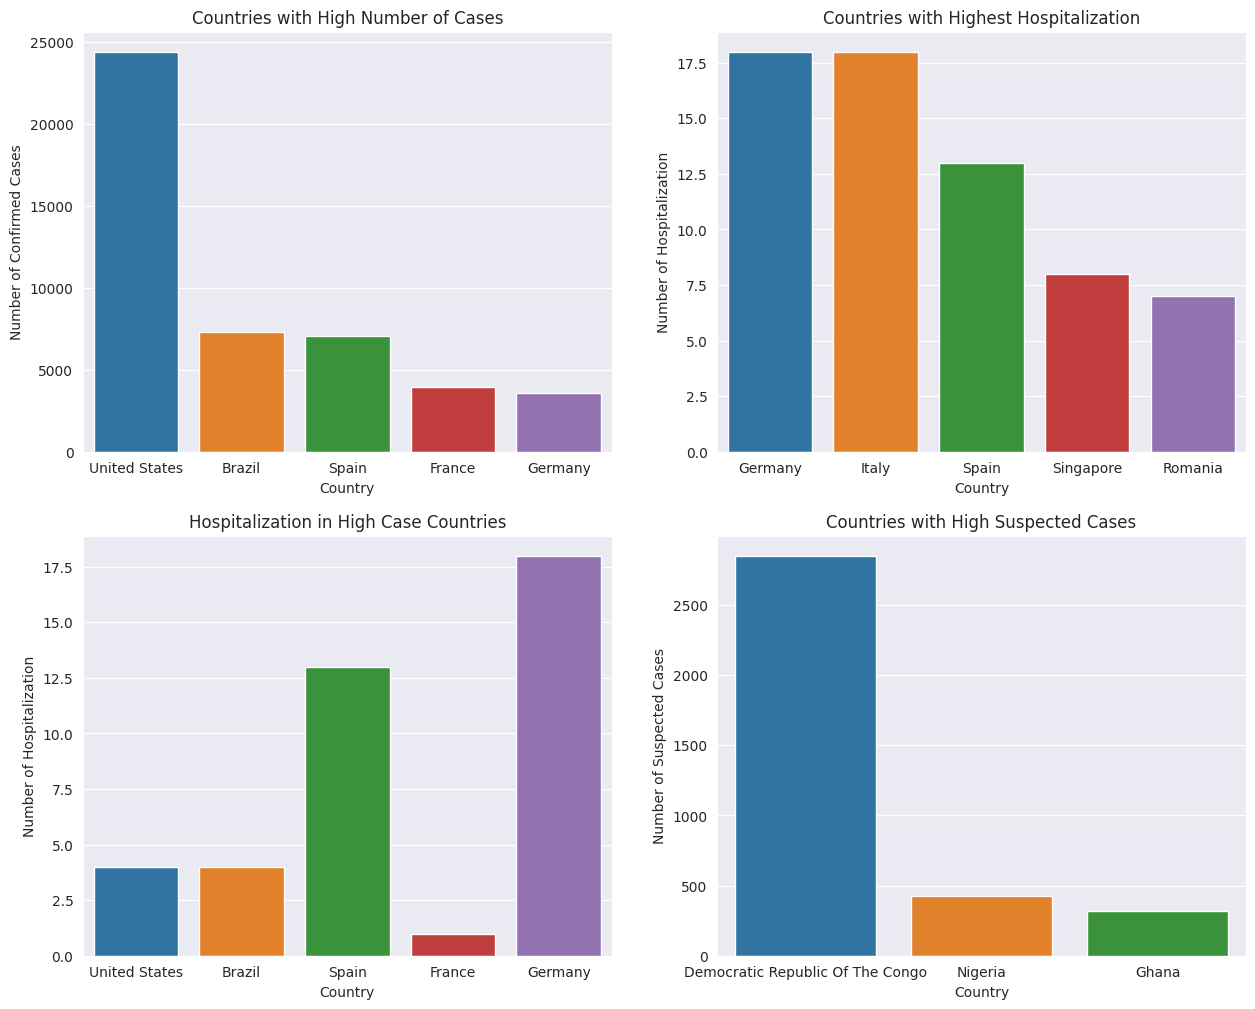

In [ ]:
#Creating some barplots to discover data
plt.figure(figsize=(15,12))

#Finding top 5 countries with most confirmed cases
plt.subplot(2,2,1)
top_confirm = daily_cases.sort_values(by="Confirmed_Cases",ascending=False)[:5][['Country','Confirmed_Cases','Hospitalized']]
sns.barplot(x='Country', y="Confirmed_Cases", data=top_confirm)
plt.title("Countries with High Number of Cases",fontsize=12)
plt.ylabel("Number of Confirmed Cases")

#Finding top 5 countries with most hospitalized cases
plt.subplot(2,2,2)
top_hospitalized = daily_cases.sort_values(by="Hospitalized",ascending=False)[:5][['Country','Hospitalized']]
sns.barplot(x='Country', y='Hospitalized', data=top_hospitalized)
plt.title("Countries with Highest Hospitalization",fontsize=12)
plt.ylabel("Number of Hospitalization")

#Finding number of hospitalization for top 5 most affected countries
plt.subplot(2,2,3)
sns.barplot(x='Country',y="Hospitalized",data=top_confirm)
plt.title("Hospitalization in High Case Countries")
plt.ylabel("Number of Hospitalization")

#Finding top 3 countries with most suspected cases
plt.subplot(2,2,4)
top_suspected = daily_cases.sort_values(by="Suspected_Cases",ascending=False)[:3][["Country","Suspected_Cases"]]
sns.barplot(x="Country",y="Suspected_Cases",data=top_suspected)
plt.title("Countries with High Suspected Cases")
plt.ylabel("Number of Suspected Cases")

In [ ]:
#Helper function to get case timeline for a country
def timeline_extractor(timeline, country):
  country_timeline = timeline[timeline["Country"] == country].value_counts(["Date_confirmation"])
  country_timeline.index = list(reduce(operator.add, country_timeline.index))
  country_timeline.index = pd.to_datetime(country_timeline.index)
  country_timeline.index.name = "Date"
  country_timeline = country_timeline.sort_index().to_frame(name="Occurence").reset_index()

  return country_timeline

In [ ]:
#Making a new figure to draw line graphs of most affected countries
fig = make_subplots(rows=2, cols=2, subplot_titles=("United States", "Brazil", "Spain", "Germany"))

#Drawing line graph of case timeline for United States
us_timeline = timeline_extractor(daily_timeline,"United States")
fig.add_trace(go.Scatter(x = us_timeline.Date, y = us_timeline.Occurence, name = "United States"),row=1,col=1)

#Drawing line graph of case timeline for Brazil
brazil_timeline = timeline_extractor(daily_timeline,"Brazil")
fig.add_trace(go.Scatter(x = brazil_timeline.Date, y = brazil_timeline.Occurence, name = "Brazil"),row=1,col=2)

#Drawing line graph of case timeline for Spain
spain_timeline = timeline_extractor(daily_timeline,"Spain")
fig.add_trace(go.Scatter(x = spain_timeline.Date, y = spain_timeline.Occurence, name = "Spain"),row=2,col=1)

#Drawing line graph of case timeline for Germany
germany_timeline = timeline_extractor(daily_timeline,"Germany")
fig.add_trace(go.Scatter(x = germany_timeline.Date, y = germany_timeline.Occurence, name = "Germany"),row=2,col=2)

fig.update_layout(title_text="Most Affected Countries' Case Timeline",height=900,hovermode="x")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Number of Cases")

fig.show()

In [ ]:
#Setting country column as index and transposing dataframe for easy calculation
daily_cwise.set_index('Country', inplace=True)
daily_cwise = daily_cwise.T

#Summing all case values for dates
daily_cwise['Total_cases'] = daily_cwise.sum(axis=1)

#Transforming index values into datetime objects
daily_cwise.index = pd.to_datetime(daily_cwise.index)

#Making the graph
fig = px.line(daily_cwise, y='Total_cases',labels={'Total_cases':'Number of Cases','index':'Date'},
              title='Worldwide Case Timeline',color_discrete_sequence=['#6F2DBD'])
fig.update_layout(hovermode="x")
fig.show()

In [ ]:
#Drawing world map that indicates case intensity for each country
fig = px.choropleth(daily_cases.Confirmed_Cases,locations= daily_cases.Country, color_continuous_scale="Viridis",
                    locationmode="country names", color="Confirmed_Cases",title="Case Intensity World Map")
fig.show()

Text(0.5, 1.0, 'Common Symptoms')

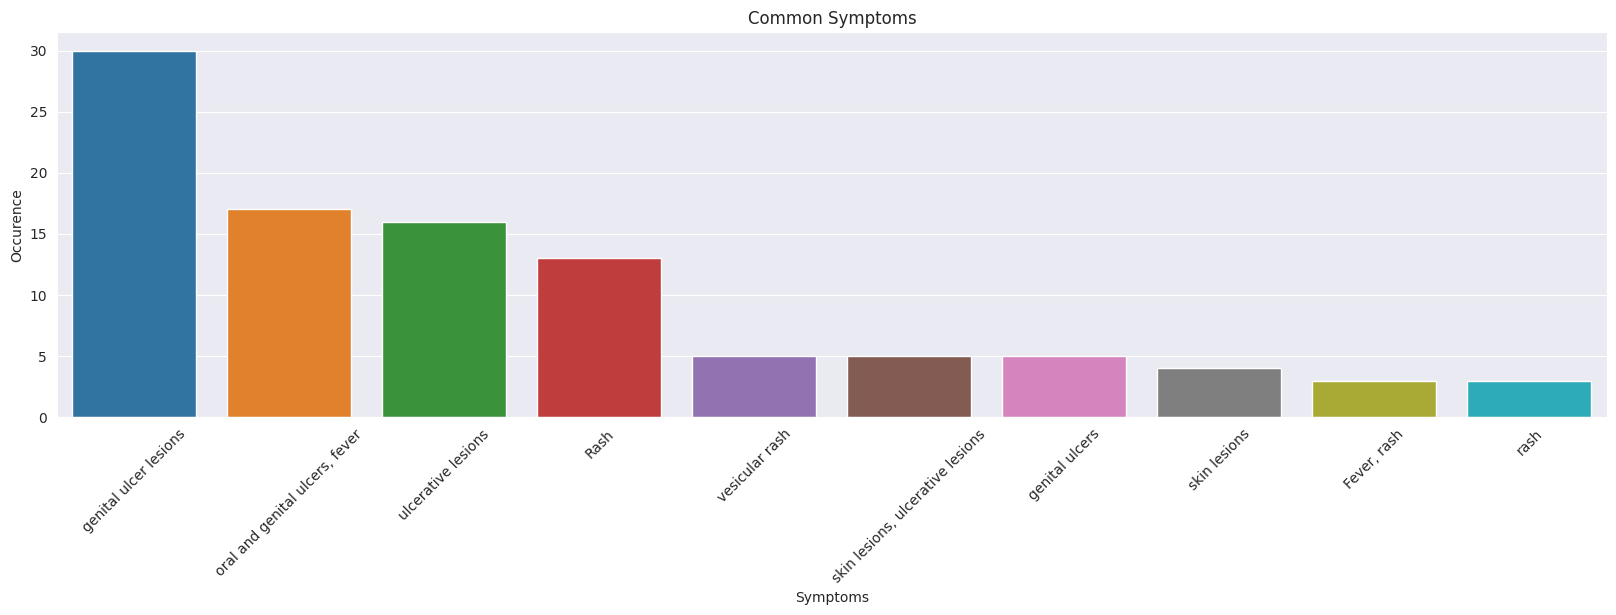

In [ ]:
#Finding most common 10 symptoms for Monkeypox Virus
plt.figure(figsize=(20,5))
common_symp = daily_timeline.value_counts(["Symptoms"])[:10].to_frame(name="Occurence").reset_index()
sns.barplot(x = common_symp.Symptoms, y = common_symp.Occurence, data=common_symp)
plt.xticks(rotation=45)
plt.title("Common Symptoms", fontsize=12)

In [ ]:
#Changing null values with 0 and age groups with their mean value
daily_timeline['Age'] = daily_timeline['Age'].fillna('0')
daily_timeline['Age'] = daily_timeline['Age'].apply(lambda x: np.array(x.split('-'), dtype=int).mean())
daily_timeline['Age'] = np.ceil(daily_timeline['Age']).astype(int)

#Visualizing most affected age groups
ages_selected = daily_timeline[daily_timeline['Age']>0]
fig = px.histogram(ages_selected,x='Age',nbins=25,color_discrete_sequence = px.colors.qualitative.Set3, title="Age groups affected by virus")
fig.show()

In [ ]:
#Data cleaning and formatting on Gender column
daily_timeline['Gender'] = daily_timeline['Gender'].str.strip()
daily_timeline['Gender'] = daily_timeline['Gender'].str.lower()
daily_timeline['Gender'] = daily_timeline['Gender'].replace(np.nan,'Unknown')

#Finding gender distribution
gender_dist = daily_timeline[daily_timeline.Gender != "Unknown"].value_counts(["Gender"]).to_frame(name="Number").reset_index()

#Visualizing gender distribution
fig = px.pie(gender_dist, names="Gender",values="Number",title="Gender Distribution")
fig.show()